<a href="https://colab.research.google.com/github/SergeiVKalinin/MSE_Fall_2025/blob/main/Module%204/18_Clustering_EELS_tSNE_ISOMAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tutorial notebook for the Fall 2025 Course "Machine Learning for Materials Science", University of Tennessee Knoxville, Department of Materials Science and Engineering.

- Instructor Sergei V. Kalinin
- EELS data by Kevin Roccapriore, Oak Ridge National Laboratory

Special point:
- ChatGPT will augment your power as a coder
- If and only if you know what you want to accomplish!

In [1]:
from copy import deepcopy as dc

import numpy as np
from sklearn import decomposition

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

Download EELS data. This is 12 EELS spectral data sets of indium-tin oxide cubes aquired by Kevin Roccapriore, measured at different resolutions and geometries. Pick the one you like!

In [2]:
%%capture
!wget https://www.dropbox.com/s/nicyvttpihzh1cd/Plasmonic_sets_7222021_fixed.npy
loadedfile = np.load("Plasmonic_sets_7222021_fixed.npy", allow_pickle=True).tolist()

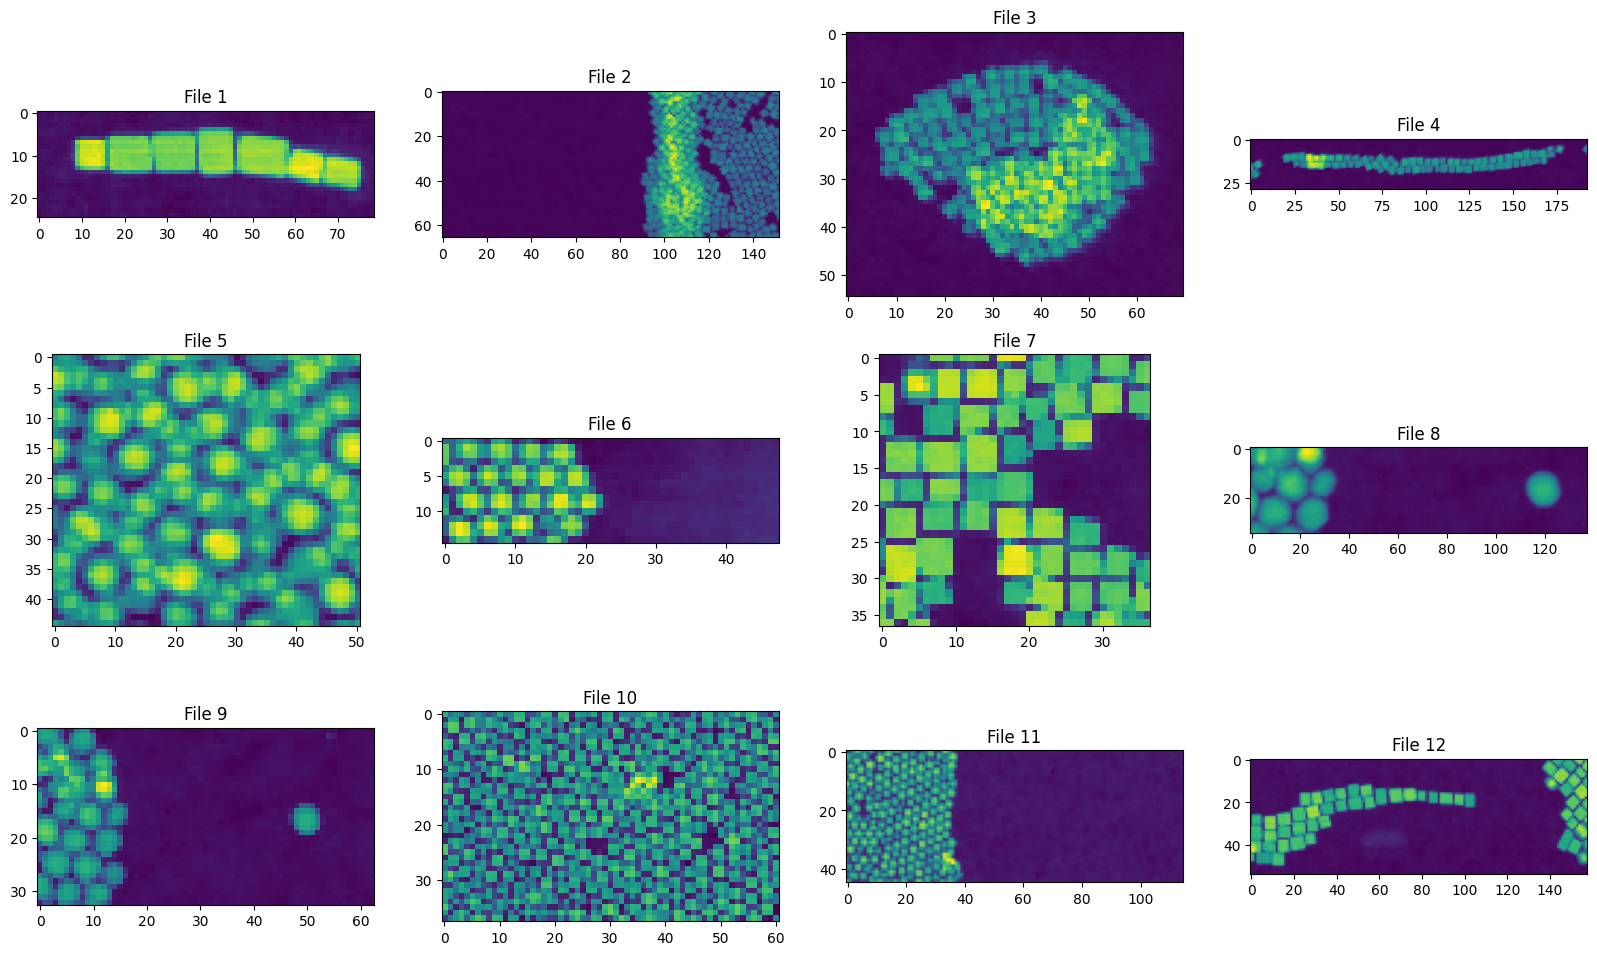

In [3]:
num_im = len(loadedfile)
rows = int(np.ceil(float(num_im)/4))
cols = int(np.ceil(float(num_im)/rows))

gs = gridspec.GridSpec(rows, cols)
fig = plt.figure(figsize = (5*cols, 3*(1+rows)))

for kk in range(num_im):
    ax = fig.add_subplot(gs[kk])
    fileset  = loadedfile['{}'.format(kk+1)]
    f1,f2,f3,f4 = fileset
    img, data, e_ax, img_scale = fileset[f1], fileset[f2], fileset[f3], fileset[f4]
    ax.imshow(img)
    ax.set_title("File {}".format(kk+1))

In [4]:
# Choose the file for analysis

k = 5 #3
img = loadedfile['{}'.format(k)]['image']
specim = loadedfile['{}'.format(k)]['spectrum image']
e_ax = loadedfile['{}'.format(k)]['energy axis']
imscale = loadedfile['{}'.format(k)]['scale']

In [5]:
# Read grid spectoscopy data

hdata = specim
hdata = hdata.astype(np.float64)

Visual inspection of the :

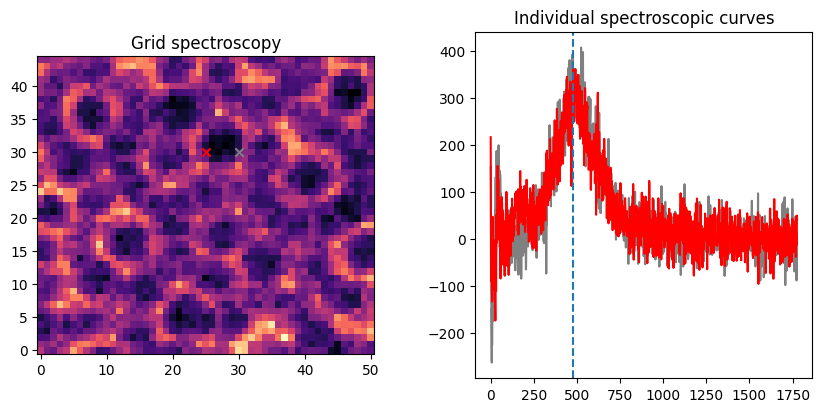

In [6]:
# Select a slice and points for extracting idividual spectoscopic curves
# For convenience, we look at the data in pixels (however, we store the real scale as e_ax)

s = 480 # slice
pos1 = [30, 30]
pos2 = [25, 30]

# Plot
_, ax = plt.subplots(1, 2, figsize=(10, 4.5))
ax[0].imshow(hdata[..., s], cmap='magma', origin="lower")
ax[0].scatter(pos1[0], pos1[1], c='gray', marker='x')
ax[1].plot(hdata[pos1[1], pos1[0], :], c='gray')
ax[0].scatter(pos2[0], pos2[1], c='red', marker='x')
ax[1].plot(hdata[pos2[1], pos2[0], :], c='red')
ax[1].axvline(x=s, linestyle = '--')
ax[0].set_title('Grid spectroscopy')
ax[1].set_title('Individual spectroscopic curves')
plt.subplots_adjust(wspace=.3)

Important considerations for subsequent analysis.
 - For "real" analysis, make sure that before any subsequent analysis the data is properly curated. For EELS this is zero loss peak subtraction and log-log deconvolution. This will affect analysis very strongly (e.g. zerol-loss peak will dominate everything if not accounted for).
 - You can also consider downsampling the data (just average pool).
 - Finally, always keep track on whether you normalize data and how (all spectra 0 to 1, or all normalized to total maximum)
 - And keep track on whether average is subtracted.
 - Normalization and average subtraction will affect the analysis results. In our experience, there is no right way or wrong way for doing it - different preprocessing highlights dissimilar aspects of the physics of the system. However, it is important to keep track of these.  

In [7]:
X_vec = hdata.copy()
d1, d2, d3 = X_vec.shape
X_vec = X_vec.reshape(d1*d2, d3)
X_vec = (X_vec - np.min(X_vec)) / np.ptp(X_vec)

In [8]:
d1, d2, d3

(45, 51, 1777)

# K Means Clustering

Here we will do k-means clustering by using the scikit-learn package

In [9]:
## import library
from sklearn.cluster import KMeans

n_clusters = 7

km = KMeans(n_clusters) #choose number of clusters
km_results = km.fit(np.array(X_vec)) #we can intelligently fold the data and perform Kmeans

#Get the cluster centers and the labels
km_labels = km_results.labels_
km_centers = km_results.cluster_centers_

#Reshape the labels
km_labels = km_labels.reshape(d1, d2)

/tmp/ipython-input-998744538.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('jet', km.n_clusters) #make a colormap, number of colors being the number of clusters


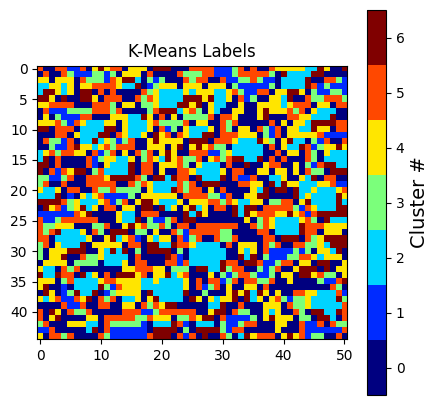

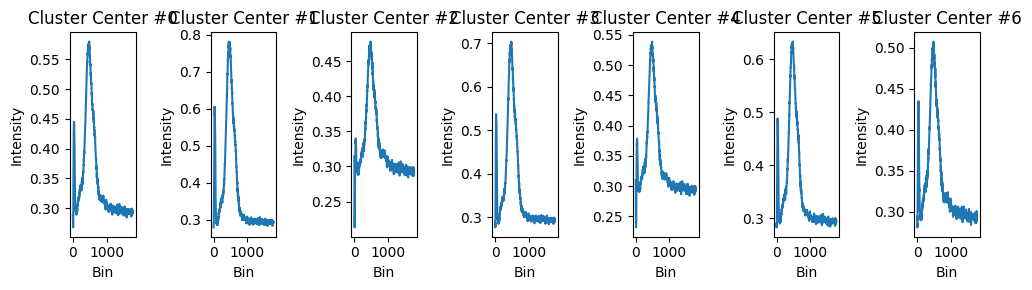

In [10]:
#Plot the results

#Plot the labels
cmap = plt.cm.get_cmap('jet', km.n_clusters) #make a colormap, number of colors being the number of clusters

#Plot the cluster labels
fig, axes = plt.subplots(figsize=(5,5))
im = axes.imshow(km_labels, cmap=cmap,vmin=np.min(km_labels) - 0.5,
                      vmax=np.max(km_labels) + 0.5)
axes.set_title('K-Means Labels')
cbar = fig.colorbar(im, ax=axes)
cbar.ax.set_yticks(np.arange(np.min(km_labels), np.max(km_labels) + 1))
cbar.ax.set_ylabel("Cluster #", fontsize = 14)

#Plot the cluster centers
fig, axes = plt.subplots(nrows=1, ncols=km.n_clusters, figsize = (10,3))
for ind, ax in enumerate(axes.flat):
    ax.plot(km_centers[ind,:])
    ax.set_title('Cluster Center #' + str(ind))
    ax.set_ylabel("Intensity")
    ax.set_xlabel("Bin")
fig.tight_layout()

# t-SNE

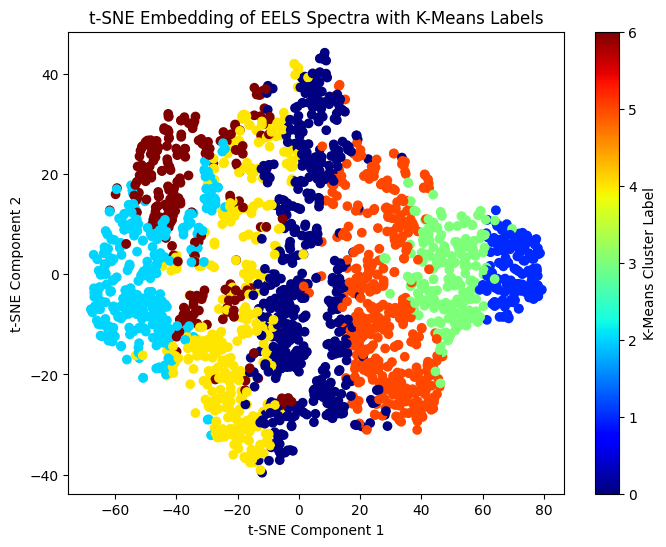

In [11]:
# prompt: generate t-SNE embedding of the X_vec and visualzie it. Use k-means labels as colors

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X_vec)

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=km_labels.flatten(), cmap='jet', marker='o')
plt.title('t-SNE Embedding of EELS Spectra with K-Means Labels')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='K-Means Cluster Label')
plt.show()


# UMAP


In [12]:
!pip install umap-learn

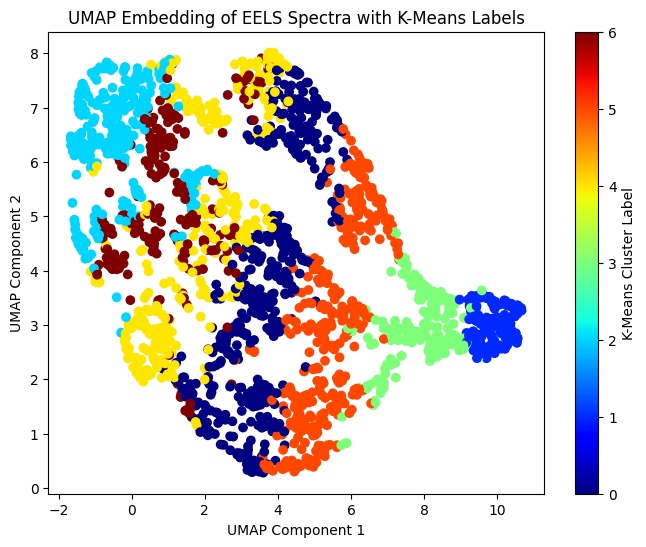

In [13]:
import umap

reducer = umap.UMAP()
embedding = reducer.fit_transform(X_vec)

plt.figure(figsize=(8, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], c=km_labels.flatten(), cmap='jet', marker='o')
plt.title('UMAP Embedding of EELS Spectra with K-Means Labels')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.colorbar(label='K-Means Cluster Label')
plt.show()

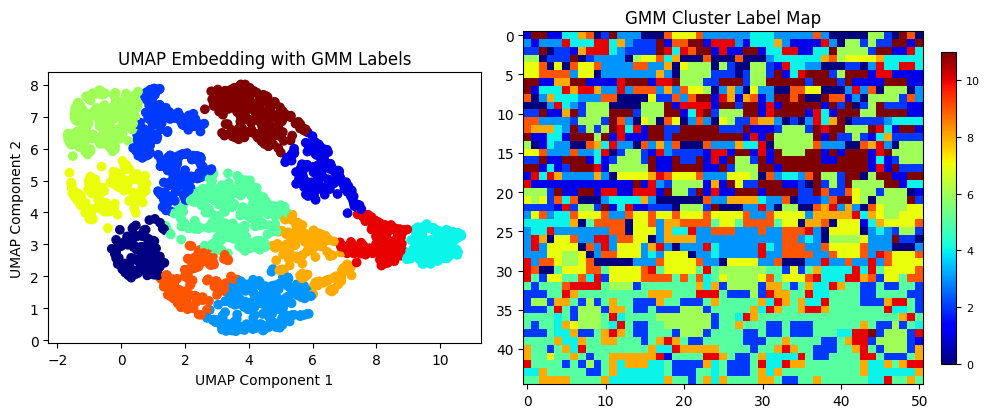

In [14]:
from sklearn.mixture import GaussianMixture

# GMM clustering on UMAP embeddings
gmm = GaussianMixture(n_components=12, random_state=0)
gmm_labels = gmm.fit_predict(embedding)

# Visualize UMAP space with GMM cluster labels and label map side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# UMAP embedding with GMM labels
scatter = axes[0].scatter(embedding[:, 0], embedding[:, 1], c=gmm_labels, cmap='jet', marker='o')
axes[0].set_title('UMAP Embedding with GMM Labels')
axes[0].set_xlabel('UMAP Component 1')
axes[0].set_ylabel('UMAP Component 2')
axes[0].set_aspect('equal')

# Label map
gmm_labels_image = gmm_labels.reshape(d1, d2)  # Reshape GMM labels for the map
im = axes[1].imshow(gmm_labels_image, cmap='jet')
axes[1].set_title('GMM Cluster Label Map')
axes[1].set_aspect('equal')

# Add a smaller colorbar for the label map
cbar = fig.colorbar(im, ax=axes[1], fraction=0.036, pad=0.04)
cbar.ax.tick_params(labelsize=8)  # Make colorbar labels smaller

# Set equal aspect ratio and size for both images
for ax in axes:
    ax.set_aspect('equal')

fig.tight_layout()
plt.show()

In [15]:
np.unique(gmm_labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

# NMF

In [16]:
hdata.shape

(45, 51, 1777)

/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


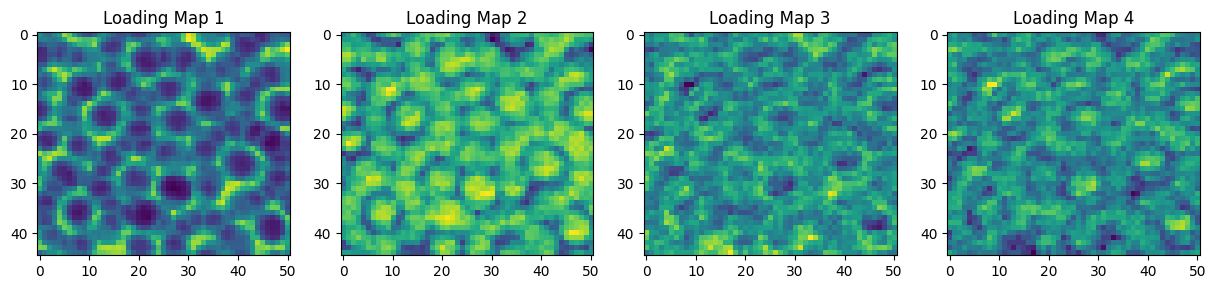

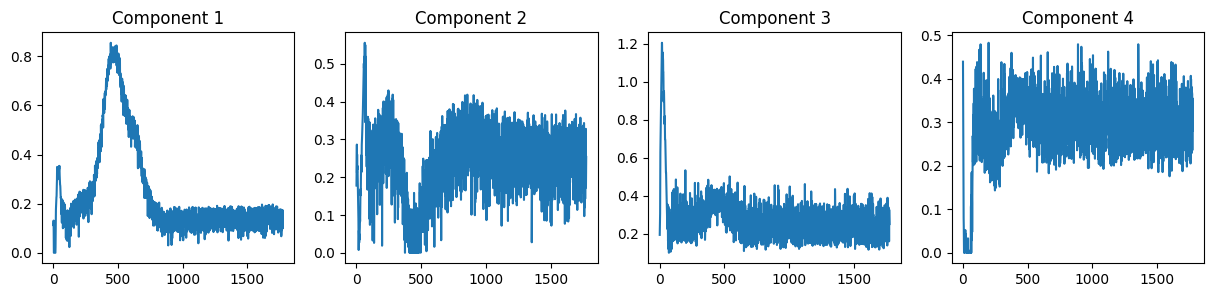

In [17]:
from sklearn.decomposition import NMF

# Normalize hdata
hdata_norm = (hdata - np.min(hdata)) / np.ptp(hdata)

# Reshape data for NMF
X_nmf = hdata_norm.reshape(d1 * d2, d3)

# Apply NMF
n_components = 4
model = NMF(n_components=n_components, init='random', random_state=0)
W = model.fit_transform(X_nmf)
H = model.components_

# Reshape W for visualization (loading maps)
W_image = W.reshape(d1, d2, n_components)

# Plot loading maps
fig, axes = plt.subplots(1, n_components, figsize=(15, 3))
for i in range(n_components):
    axes[i].imshow(W_image[:, :, i], cmap='viridis')
    axes[i].set_title(f'Loading Map {i+1}')

# Plot components
fig, axes = plt.subplots(1, n_components, figsize=(15, 3))
for i in range(n_components):
    axes[i].plot(H[i, :])
    axes[i].set_title(f'Component {i+1}')

plt.show()


# Factor Analysis

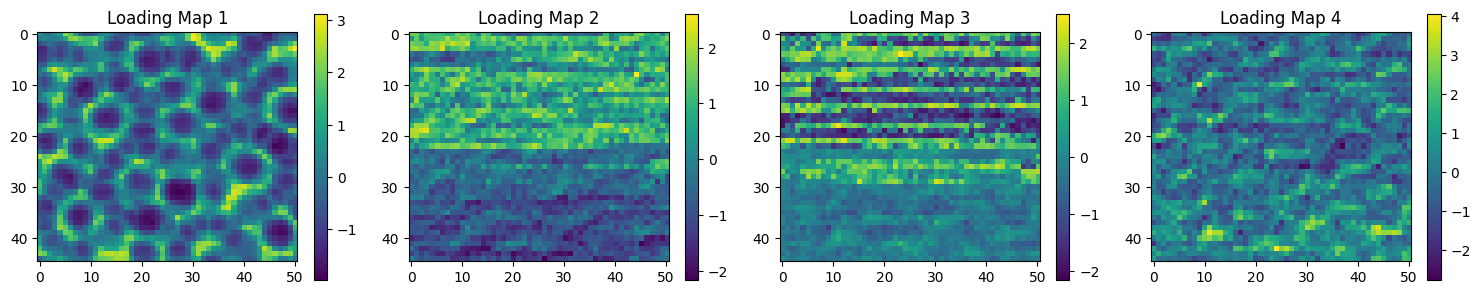

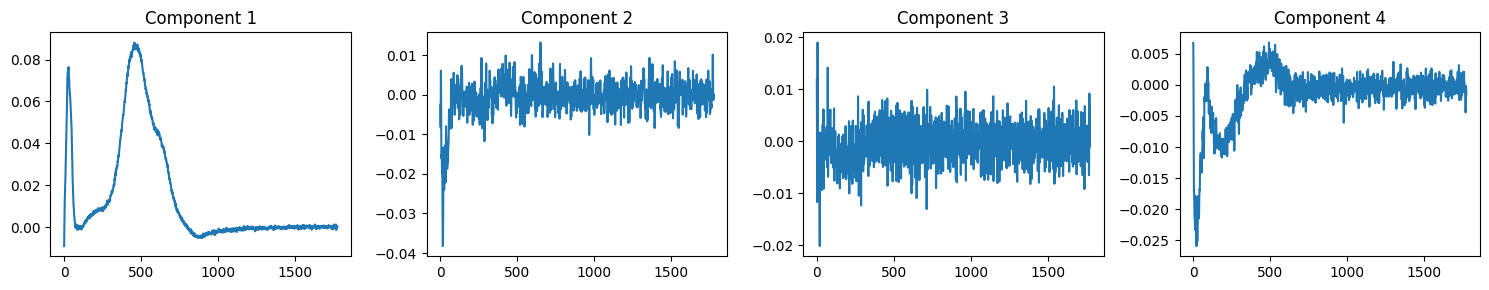

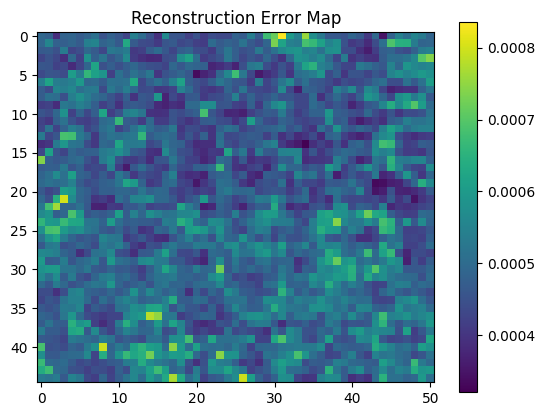

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FactorAnalysis

# Example input data (replace X_nmf with your actual data)
# Assuming X_nmf is (n_samples, n_features)
# d1 and d2 are the dimensions to reshape the data for visualization

# Apply Factor Analysis
n_components = 4
model = FactorAnalysis(n_components=n_components, random_state=0)
W = model.fit_transform(X_nmf)  # W contains the latent factors
H = model.components_  # H contains the components (factor loadings)

# Reshape W for visualization (assuming 2D spatial data)
# Adjust d1 and d2 based on your data's shape
W_image = W.reshape(d1, d2, n_components)

# Plot loading maps (W)
fig, axes = plt.subplots(1, n_components, figsize=(15, 3))
for i in range(n_components):
    im = axes[i].imshow(W_image[:, :, i], cmap='viridis')
    axes[i].set_title(f'Loading Map {i+1}')
    plt.colorbar(im, ax=axes[i])

plt.tight_layout()
plt.show()

# Plot components (H)
fig, axes = plt.subplots(1, n_components, figsize=(15, 3))
for i in range(n_components):
    axes[i].plot(H[i, :])
    axes[i].set_title(f'Component {i+1}')

plt.tight_layout()
plt.show()

# Manually reconstruct the data
# reconstructed_data = (W @ H) + mean_of_X
mean_X = np.mean(X_nmf, axis=0)
reconstructed_data = np.dot(W, H) + mean_X  # Dot product of W and H, then add the mean

# Calculate the reconstruction error (mean squared error per sample)
error = np.mean((X_nmf - reconstructed_data)**2, axis=1)
error_image = error.reshape(d1, d2)  # Reshape error for visualization

# Plot the error map
plt.figure()
plt.imshow(error_image, cmap='viridis')
plt.title('Reconstruction Error Map')
plt.colorbar()
plt.show()


[[ 1.00000000e+00 -1.80557441e-10 -3.14811976e-10 -3.15440019e-10]
 [-1.80557441e-10  1.00000000e+00  2.29329565e-04  2.22211683e-04]
 [-3.14811976e-10  2.29329565e-04  1.00000000e+00  3.91215409e-04]
 [-3.15440019e-10  2.22211683e-04  3.91215409e-04  1.00000000e+00]]


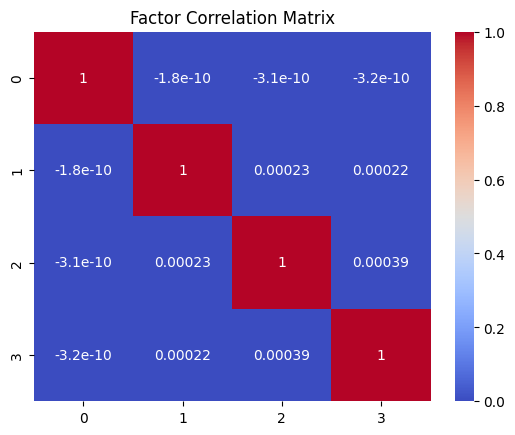

In [19]:
factor_correlation_matrix = np.corrcoef(W, rowvar=False)

# Print or visualize the correlation matrix
print(factor_correlation_matrix)

# You can also create a heatmap using seaborn or matplotlib
import seaborn as sns
sns.heatmap(factor_correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Factor Correlation Matrix')
plt.show()


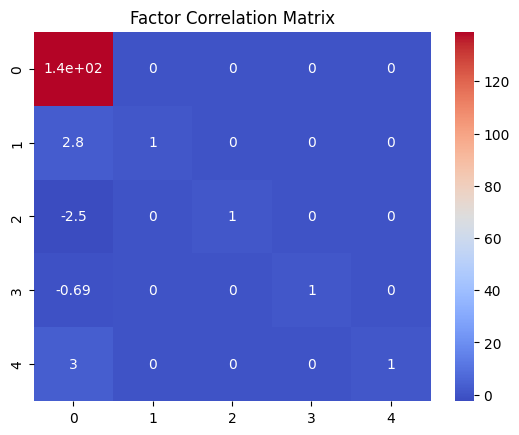

Optimized Rotation Matrix:
 [[138.98903847   0.           0.           0.           0.        ]
 [  2.75570297   1.           0.           0.           0.        ]
 [ -2.53514957   0.           1.           0.           0.        ]
 [ -0.6920681    0.           0.           1.           0.        ]
 [  3.03027439   0.           0.           0.           1.        ]]
Maximized Integral (AUC) of Squared Factor Loadings for Factor 1:  1305.7070039467626


In [20]:
import numpy as np
from sklearn.decomposition import FactorAnalysis
from scipy.optimize import minimize

# Example data (replace X_nmf with your actual data)
X_nmf = np.random.random((100, 10))  # 100 samples, 10 features

# Step 1: Perform initial Factor Analysis (FA)
n_components = 5  # Assume we want 5 factors
fa = FactorAnalysis(n_components=n_components, random_state=0)
factors = fa.fit_transform(X_nmf)  # Latent factors (initial)
factor_loadings = fa.components_  # Get initial factor loadings

# Step 2: Define the objective function to maximize the integral of squared loadings
def objective_function(rotation_params, loadings):
    # Reshape rotation parameters into a square matrix (for n_components factors)
    rotation_matrix = rotation_params.reshape((n_components, n_components))

    # Apply the rotation matrix to the factor loadings
    rotated_loadings = np.dot(loadings.T, rotation_matrix).T

    # We aim to maximize the sum of squares (integral) of the first factor (factor 1)
    factor_of_interest = rotated_loadings[0, :]  # Select the first factor

    # Sum of squared loadings (equivalent to integral for discrete data)
    auc = np.sum(factor_of_interest**2)  # Equivalent to the "energy" in the first factor

    # Negate because we are minimizing in optimization (we want to maximize AUC)
    return -auc

# Step 3: Set up the initial rotation matrix (identity matrix, no rotation initially)
initial_rotation_matrix = np.eye(n_components).flatten()  # Flatten to fit optimizer

# Step 4: Optimize the rotation matrix to maximize the AUC (integral of squared loadings)
result = minimize(objective_function, initial_rotation_matrix, args=(factor_loadings,), method='BFGS')

# Step 5: Extract the optimized rotation matrix and apply it
optimal_rotation_matrix = result.x.reshape((n_components, n_components))
rotated_loadings = np.dot(factor_loadings.T, optimal_rotation_matrix).T

sns.heatmap(optimal_rotation_matrix, annot=True, cmap='coolwarm')
plt.title('Factor Correlation Matrix')
plt.show()

# Step 6: Print results
print("Optimized Rotation Matrix:\n", optimal_rotation_matrix)
print("Maximized Integral (AUC) of Squared Factor Loadings for Factor 1: ", -result.fun)

# You can now use the rotated loadings in further analyses


# Multiple Linear Methods

/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


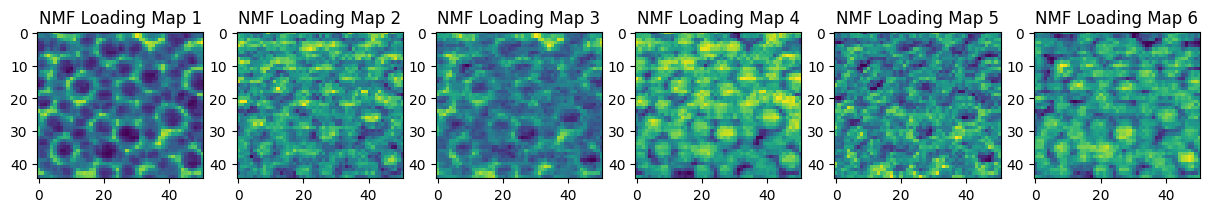

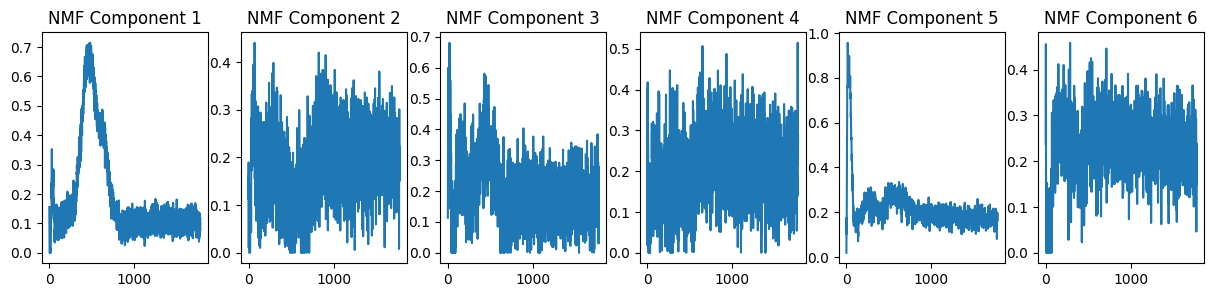

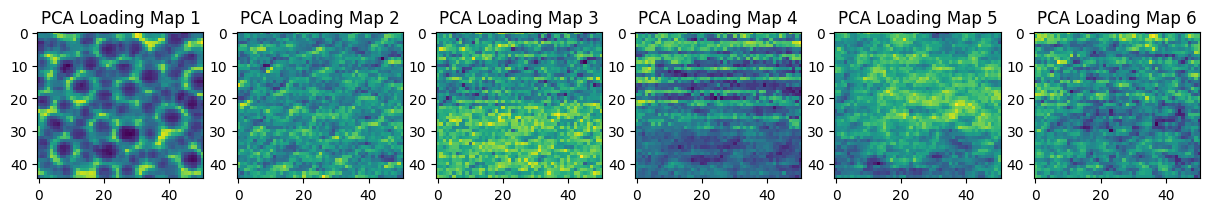

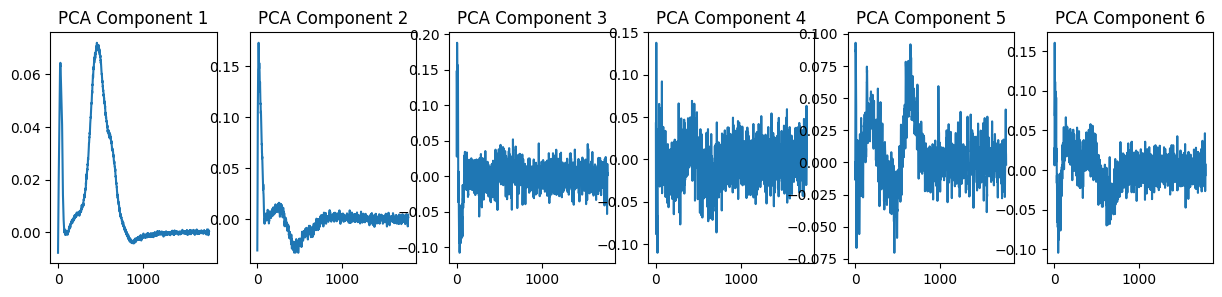

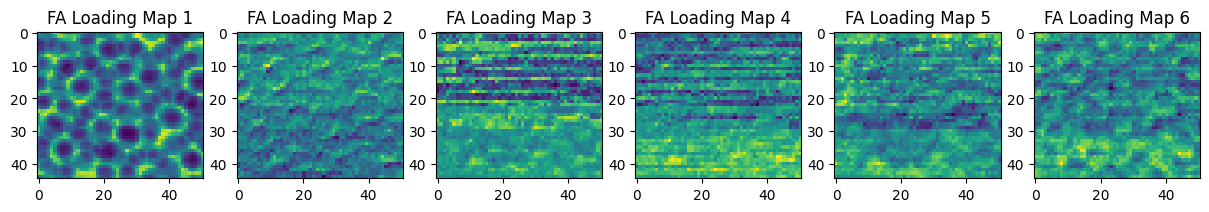

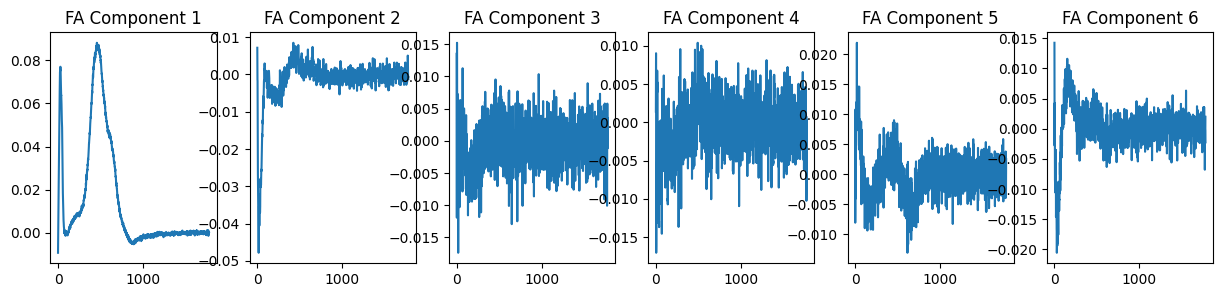

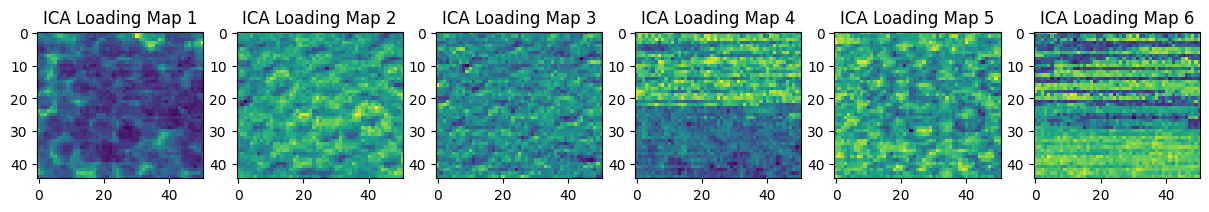

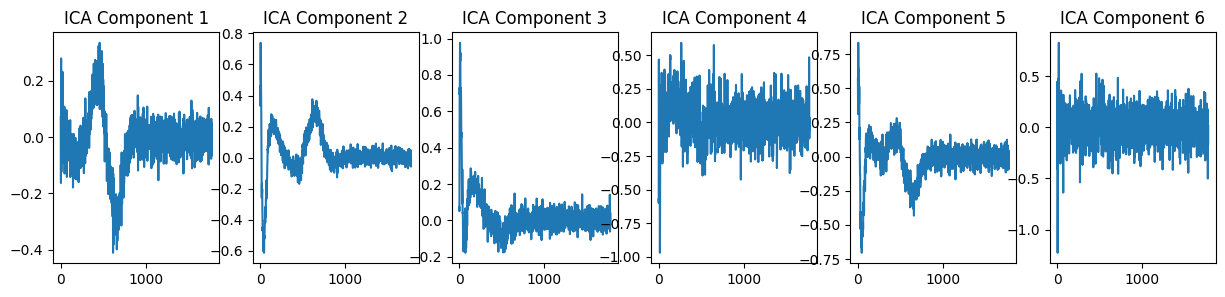

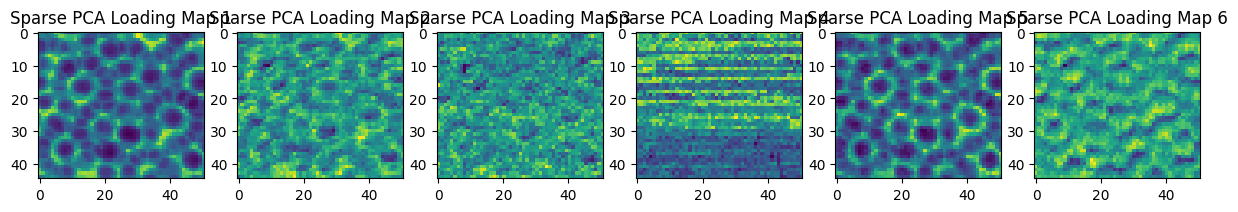

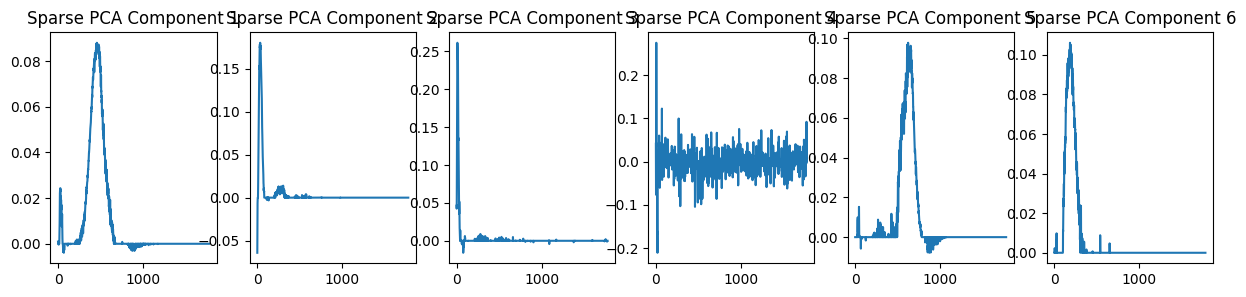

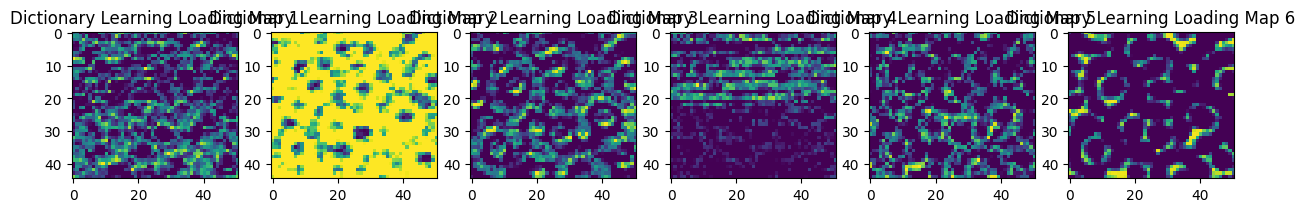

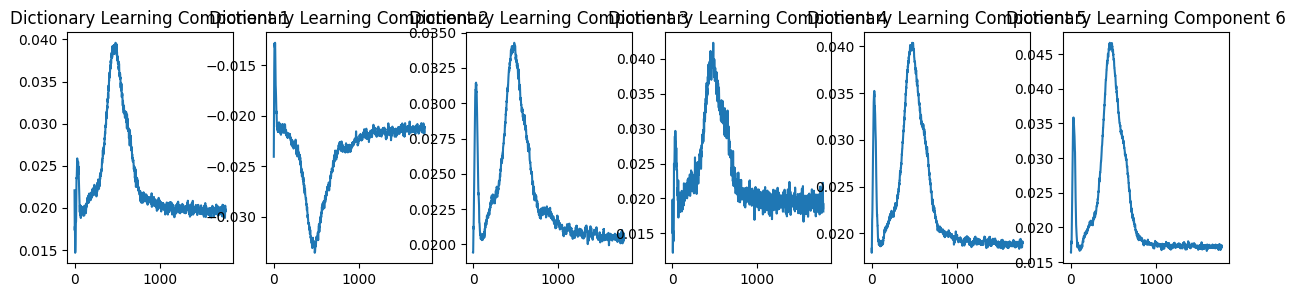

'\n# Plot LDA topic distributions (since LDA doesn\'t provide loadings in the same way)\nplt.figure(figsize=(10, 6))\nfor i, topic in enumerate(lda_components):\n    plt.plot(topic, label=f\'Topic {i+1}\')\nplt.title("LDA Topic Distributions")\nplt.legend()\nplt.show()\n'

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF, PCA, FactorAnalysis, FastICA, SparsePCA, DictionaryLearning, LatentDirichletAllocation

# Normalize hdata
hdata_norm = (hdata - np.min(hdata)) / np.ptp(hdata)

# Reshape data for analysis
X = hdata_norm.reshape(d1 * d2, d3)

# Number of components
n_components = 6

# Apply NMF
nmf_kwargs = {'n_components': n_components, 'init': 'random', 'random_state': 0, 'max_iter': 200}
nmf_model = NMF(**nmf_kwargs)
W_nmf = nmf_model.fit_transform(X)
H_nmf = nmf_model.components_

# Apply PCA
pca_kwargs = {'n_components': n_components, 'svd_solver': 'auto', 'random_state': 0}
pca_model = PCA(**pca_kwargs)
W_pca = pca_model.fit_transform(X)
H_pca = pca_model.components_

# Apply Factor Analysis
fa_kwargs = {'n_components': n_components, 'random_state': 0, 'max_iter': 200, 'tol': 0.01}
fa_model = FactorAnalysis(**fa_kwargs)
W_fa = fa_model.fit_transform(X)
H_fa = fa_model.components_

# Apply ICA
ica_kwargs = {'n_components': n_components, 'random_state': 0, 'max_iter': 200, 'tol': 0.01}
ica_model = FastICA(**ica_kwargs)
W_ica = ica_model.fit_transform(X)
H_ica = ica_model.components_

# Apply Sparse PCA
sparse_pca_kwargs = {'n_components': n_components, 'alpha': 0.1, 'random_state': 0, 'ridge_alpha': 0.01, 'max_iter': 200}
sparse_pca_model = SparsePCA(**sparse_pca_kwargs)
W_sparse_pca = sparse_pca_model.fit_transform(X)
H_sparse_pca = sparse_pca_model.components_

# Apply Dictionary Learning
dl_kwargs = {'n_components': n_components, 'alpha': 1.0, 'random_state': 0, 'max_iter': 200}
dl_model = DictionaryLearning(**dl_kwargs)
W_dl = dl_model.fit_transform(X)
H_dl = dl_model.components_

'''
# Apply Latent Dirichlet Allocation (LDA)
lda_kwargs = {'n_components': n_components, 'learning_method': 'batch', 'max_iter': 10, 'random_state': 0}
lda_model = LatentDirichletAllocation(**lda_kwargs)
lda_topics = lda_model.fit_transform(X)  # LDA gives topic proportions instead of components
lda_components = lda_model.components_
'''

# Reshape results for visualization (only applicable for factorization methods, not LDA)
def reshape_components(W):
    return W.reshape(d1, d2, n_components)

# Plot loading maps and components for each method
methods = {
    'NMF': (W_nmf, H_nmf),
    'PCA': (W_pca, H_pca),
    'FA': (W_fa, H_fa),
    'ICA': (W_ica, H_ica),
    'Sparse PCA': (W_sparse_pca, H_sparse_pca),
    'Dictionary Learning': (W_dl, H_dl)
}

for method, (W, H) in methods.items():
    W_image = reshape_components(W)

    # Plot loading maps
    fig, axes = plt.subplots(1, n_components, figsize=(15, 3))
    for i in range(n_components):
        axes[i].imshow(W_image[:, :, i], cmap='viridis')
        axes[i].set_title(f'{method} Loading Map {i+1}')

    # Plot components
    fig, axes = plt.subplots(1, n_components, figsize=(15, 3))
    for i in range(n_components):
        axes[i].plot(H[i, :])
        axes[i].set_title(f'{method} Component {i+1}')
    plt.show()

'''
# Plot LDA topic distributions (since LDA doesn't provide loadings in the same way)
plt.figure(figsize=(10, 6))
for i, topic in enumerate(lda_components):
    plt.plot(topic, label=f'Topic {i+1}')
plt.title("LDA Topic Distributions")
plt.legend()
plt.show()
'''

Note that analysis below is very time consuming

In [22]:
'''
from sklearn.decomposition import DictionaryLearning

# Define alpha values to test
alpha_values = [0.01, 0.1, 1, 10, 100]

# Number of components
n_components = 4

# Initialize figure for loading maps
fig, axes = plt.subplots(len(alpha_values), n_components, figsize=(15, 3 * len(alpha_values)))

# Loop over different alpha values
for i, alpha in enumerate(alpha_values):

    print(alpha)

    # Update kwargs for Dictionary Learning
    dl_kwargs = {'n_components': n_components, 'alpha': alpha, 'random_state': 0, 'max_iter': 200}

    # Apply Dictionary Learning
    dl_model = DictionaryLearning(**dl_kwargs)
    W_dl = dl_model.fit_transform(X)  # Components/factors
    H_dl = dl_model.components_       # Loadings

    # Reshape W for visualization (loading maps)
    W_image = W_dl.reshape(d1, d2, n_components)

    # Plot loading maps
    for j in range(n_components):
        ax = axes[i, j]
        ax.imshow(W_image[:, :, j], cmap='viridis')
        ax.set_title(f'Alpha = {alpha}, Loading Map {j+1}')
        ax.axis('off')

plt.tight_layout()
plt.show()
'''

"\nfrom sklearn.decomposition import DictionaryLearning\n\n# Define alpha values to test\nalpha_values = [0.01, 0.1, 1, 10, 100]\n\n# Number of components\nn_components = 4\n\n# Initialize figure for loading maps\nfig, axes = plt.subplots(len(alpha_values), n_components, figsize=(15, 3 * len(alpha_values)))\n\n# Loop over different alpha values\nfor i, alpha in enumerate(alpha_values):\n\n    print(alpha)\n\n    # Update kwargs for Dictionary Learning\n    dl_kwargs = {'n_components': n_components, 'alpha': alpha, 'random_state': 0, 'max_iter': 200}\n\n    # Apply Dictionary Learning\n    dl_model = DictionaryLearning(**dl_kwargs)\n    W_dl = dl_model.fit_transform(X)  # Components/factors\n    H_dl = dl_model.components_       # Loadings\n\n    # Reshape W for visualization (loading maps)\n    W_image = W_dl.reshape(d1, d2, n_components)\n\n    # Plot loading maps\n    for j in range(n_components):\n        ax = axes[i, j]\n        ax.imshow(W_image[:, :, j], cmap='viridis')\n        

# Latent Dirichlet Allocation

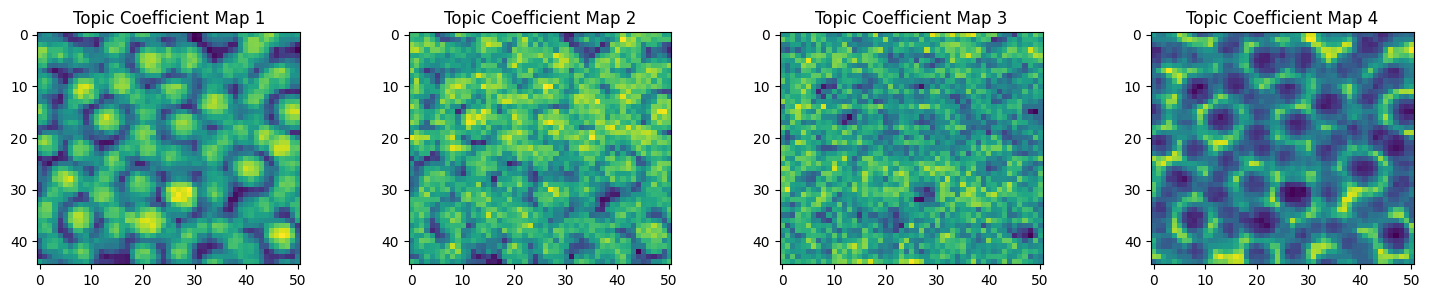

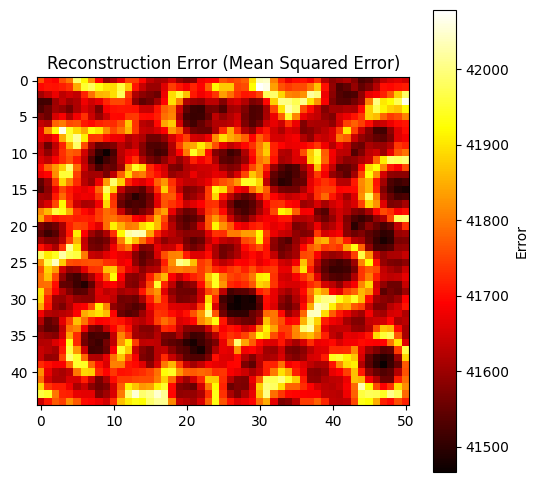

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation

# Assume hdata_norm has already been normalized and reshaped to (d1 * d2, d3)
X_lda = hdata_norm.reshape(d1 * d2, d3)

# Number of topics (components for LDA)
n_components = 4

# Apply LDA
lda_kwargs = {'n_components': n_components, 'learning_method': 'batch', 'max_iter': 10, 'random_state': 0}
lda_model = LatentDirichletAllocation(**lda_kwargs)
topic_proportions = lda_model.fit_transform(X_lda)  # Coefficients for each topic
topics = lda_model.components_  # Topic distributions (like components in other methods)

# Reconstruct the spectra using the topics and coefficients
reconstructed_data = np.dot(topic_proportions, topics)

# Calculate the error term as the difference between original and reconstructed data
error_term = X_lda - reconstructed_data

# Reshape the topic proportions and error term back to the original spatial dimensions
topic_proportions_image = topic_proportions.reshape(d1, d2, n_components)
error_term_image = error_term.reshape(d1, d2, d3)

# Visualize the coefficient maps (topic proportions) for each topic
fig, axes = plt.subplots(1, n_components, figsize=(15, 3))
for i in range(n_components):
    axes[i].imshow(topic_proportions_image[:, :, i], cmap='viridis')
    axes[i].set_title(f'Topic Coefficient Map {i+1}')
plt.tight_layout()
plt.show()

# Visualize the error term (mean squared error across spectra for each spatial point)
mean_squared_error = np.mean(np.square(error_term), axis=1).reshape(d1, d2)
plt.figure(figsize=(6, 6))
plt.imshow(mean_squared_error, cmap='hot')
plt.title('Reconstruction Error (Mean Squared Error)')
plt.colorbar(label='Error')
plt.show()


# SOM

In [24]:
# First, install MiniSom if you haven't done so
!pip install minisom

  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.5-py3-none-any.whl size=12031 sha256=9411d66b29dacedd1351c715282d5997741bfa5c8c9d962537176e889fd8a276
  Stored in directory: /root/.cache/pip/wheels/0f/8c/a4/5b7aa56fa6ef11d536d45da775bcc5a2a1c163ff0f8f11990b
Successfully built minisom


 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.5832551694657758


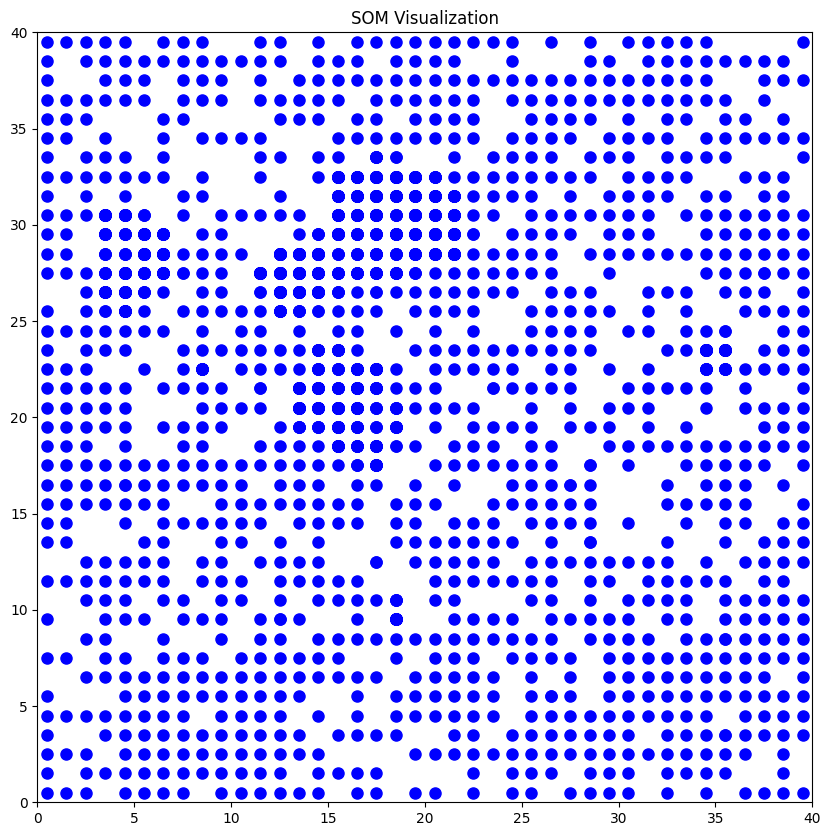

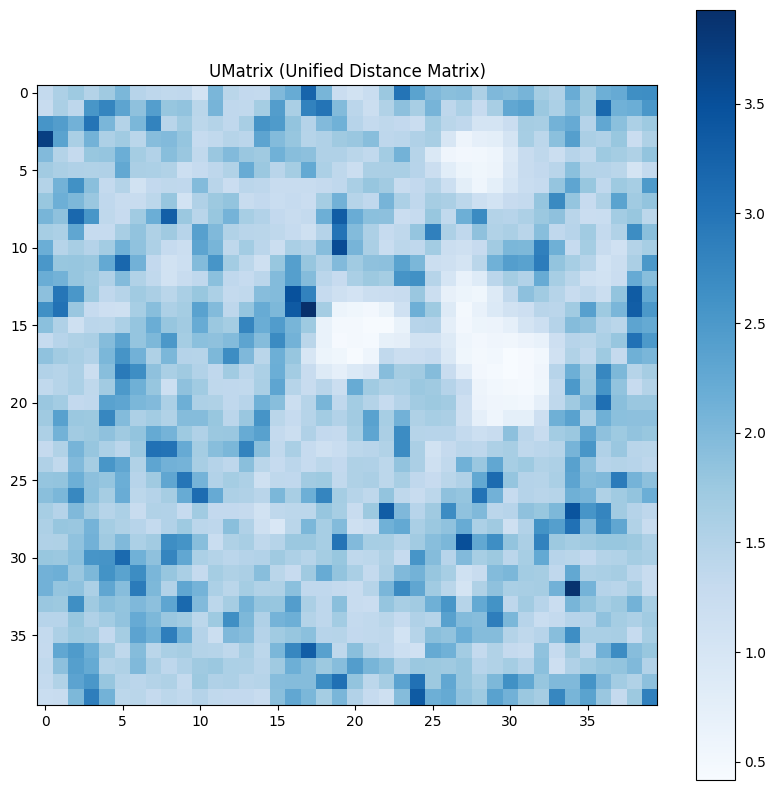

'\n# 3. Visualize the Weights of SOM neurons (shows how the SOM grid organizes input features)\nweights = som.get_weights()  # SOM neurons\' weights (features)\n\nfig, axes = plt.subplots(1, d3, figsize=(15, 5))\nfor i in range(d3):\n    # Visualizing one component (dimension) of the SOM weights at a time\n    component_grid = weights[:, :, i]  # Extracting one feature/component from the weight matrix\n    im = axes[i].imshow(component_grid, cmap=\'viridis\')\n    axes[i].set_title(f"Component {i+1}")\n    fig.colorbar(im, ax=axes[i])\n\nplt.tight_layout()\nplt.show()\n'

In [25]:
from minisom import MiniSom

# Assuming hdata_norm is your normalized data of shape (d1, d2, d3)
# Reshape the data for SOM (flatten the first two dimensions)
X_som = hdata_norm.reshape(d1 * d2, d3)

# Initialize SOM
som_grid_size = (40, 40)  # Adjust grid size as needed
som = MiniSom(som_grid_size[0], som_grid_size[1], d3, sigma=1.0, learning_rate=0.5)
som.random_weights_init(X_som)

# Train SOM
som.train_batch(X_som, 1000, verbose=True)  # Training with 1000 iterations

# =========================
# SOM Outputs Visualization
# =========================

# 1. Visualize the SOM (data points mapped to the SOM grid)
plt.figure(figsize=(10, 10))

# If you have cluster labels (like K-means labels), use them; otherwise, just visualize the winning neurons
for i, x in enumerate(X_som):
    w = som.winner(x)  # Find the winning neuron for this data point
    plt.plot(w[0] + 0.5, w[1] + 0.5, 'bo', markersize=8)  # Plot the point at the winning neuron

plt.title("SOM Visualization")
plt.axis([0, som_grid_size[0], 0, som_grid_size[1]])
plt.show()

# 2. UMatrix (Unified Distance Matrix) Visualization
# UMatrix represents the distance between neighboring neurons (shows cluster boundaries)
def calculate_umatrix(som, som_grid_size):
    weights = som.get_weights()  # Get the weights of all SOM neurons
    umatrix = np.zeros((som_grid_size[0], som_grid_size[1]))  # Initialize the UMatrix

    for i in range(som_grid_size[0]):
        for j in range(som_grid_size[1]):
            # Get the list of neighbor coordinates (directly connected neurons)
            neighbors = []
            if i > 0: neighbors.append((i-1, j))  # Upper neighbor
            if i < som_grid_size[0] - 1: neighbors.append((i+1, j))  # Lower neighbor
            if j > 0: neighbors.append((i, j-1))  # Left neighbor
            if j < som_grid_size[1] - 1: neighbors.append((i, j+1))  # Right neighbor

            # Calculate the average distance between the neuron and its neighbors
            distance_sum = 0
            for n in neighbors:
                distance_sum += np.linalg.norm(weights[i, j] - weights[n[0], n[1]])
            umatrix[i, j] = distance_sum / len(neighbors) if neighbors else 0

    return umatrix

# Plot UMatrix
umatrix = calculate_umatrix(som, som_grid_size)
plt.figure(figsize=(10, 10))
plt.imshow(umatrix, cmap='Blues')
plt.colorbar()
plt.title("UMatrix (Unified Distance Matrix)")
plt.show()

'''
# 3. Visualize the Weights of SOM neurons (shows how the SOM grid organizes input features)
weights = som.get_weights()  # SOM neurons' weights (features)

fig, axes = plt.subplots(1, d3, figsize=(15, 5))
for i in range(d3):
    # Visualizing one component (dimension) of the SOM weights at a time
    component_grid = weights[:, :, i]  # Extracting one feature/component from the weight matrix
    im = axes[i].imshow(component_grid, cmap='viridis')
    axes[i].set_title(f"Component {i+1}")
    fig.colorbar(im, ax=axes[i])

plt.tight_layout()
plt.show()
'''

Note that this code also takes quite a while

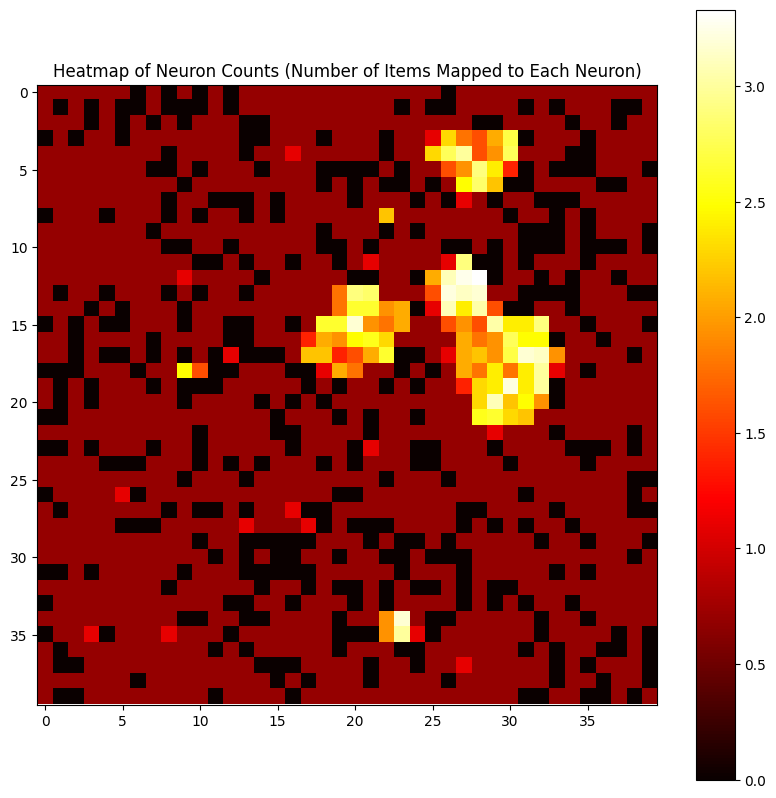

In [26]:
# prompt: Create a map where for each neuron we show how many items is there as heatmap

# Create a dictionary to store the number of items mapped to each neuron
neuron_counts = {}
for i, x in enumerate(X_som):
    w = som.winner(x)
    if w not in neuron_counts:
        neuron_counts[w] = 0
    neuron_counts[w] += 1

# Create a 2D array to store the count for each neuron
count_matrix = np.zeros((som_grid_size[0], som_grid_size[1]))
for (x, y), count in neuron_counts.items():
    count_matrix[x, y] = count

# Plot the heatmap of neuron counts
plt.figure(figsize=(10, 10))
plt.imshow(np.log(count_matrix+1), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title("Heatmap of Neuron Counts (Number of Items Mapped to Each Neuron)")
plt.show()